# Cake Classification
## Machine Learning Course Project
---
### Author: Andrea Alberti  
### Date: May 2023
---
## Data: 
The data set contains 120 images for each of 15 kinds of cake. For each class 100 images
are in the training set and 20 form the test set. All the images have been resized to
224 × 224 pixels.

## Goal:
Build classifiers for the classification of images of cakes.

---

In [1]:
import CC_functions as ccf
import numpy as np
import matplotlib.pyplot as plt
import os
import image_features
import pvml
import pandas as pd

## **NOTE**: All the features are extracted by the CC_features.py script and stored in the folder "features". In this notebook we will load the features and train the classifiers.

### 1.1 LOW LEVEL FEATURES
##### Write a script that computes one of the low-level feature vector implemented in the image_features.py file. Train a classifier and evaluate the test accuracy.

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES

#load features
list_features = ccf.load_features(['CH_test', 'CH_train'])
X_test, Y_test, X_train, Y_train = list_features

nclasses = Y_train.max() + 1

#define and train perceptron
mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_mlp', filename = 'ch_accs',store_model=True, store_accs = True)

<AxesSubplot: title={'center': 'Accuracy of MLP with histogram features'}, xlabel='Epochs (x 100)', ylabel='Accuracy (%)'>

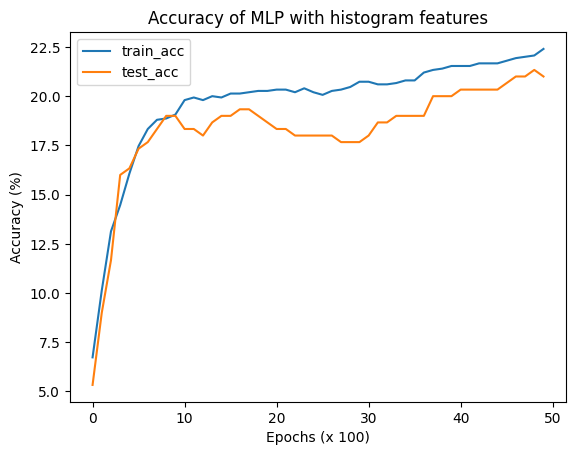

In [2]:
#show the results

df_accs = pd.read_csv('Results/CH_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epochs (x 100)', ylabel = 'Accuracy (%)')

### 1.2 NEURAL FEATURES
##### Use the pretrained PVMLNet to extract as features the activations of the last hidden layer. Train a perceptron without hidden layers and evaluate the test accuracy.

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES

#load features
list_features = ccf.load_features(['neural_test', 'neural_train'])
X_test, Y_test, X_train, Y_train = list_features

nclasses = Y_train.max() + 1

#define and train perceptron
mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'cnn_mlp', filename = 'cnn_accs',store_model=True, store_accs = True)

<AxesSubplot: title={'center': 'Accuracy of MLP with histogram features'}, xlabel='Epoch (x 100)', ylabel='Accuracy (%)'>

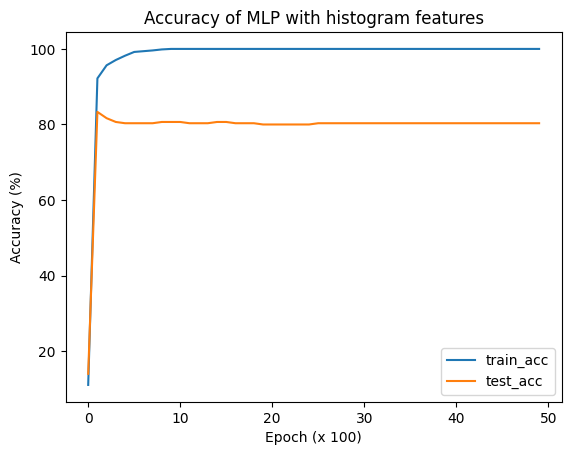

In [3]:
#show the results
df_accs = pd.read_csv('Results/cnn_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epoch (x 100)', ylabel = 'Accuracy (%)')

### 1.3 TRANSFER LEARNING
##### Build a new network by replacing the last layer of PVMLNet with the weights of the trained perceptron.

In [ ]:
#load the network
cnn = pvml.CNN.load('Trained_models/pvmlnet.npz')
mlp = pvml.MLP.load('Trained_models/cnn_mlp.npz')

#transfer the weights
cnn.weights[-1] = mlp.weights[0][None, None, :, :]
cnn.biases[-1] = mlp.biases[0]

#save the network
cnn.save("Trained_models/cnn_transfer_gitignore.npz")

classes = os.listdir('Data_gitignore/cake-classification/test')
imagename = 'ice_cream/45200.jpg'

#returns probability of 5 most likely classes for imagename
ccf.item_prediction(imagename, classes, cnn)

In [ ]:
#Use the new model to make inference

data = np.loadtxt("Features/neural_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

classes = os.listdir("Data_gitignore/cake-classification/test")
path = "Data_gitignore/cake-classification/test"

cnn_transfer = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')
all_predictions = []
for klass_label, klass in enumerate(classes):
    image_files = os.listdir(path + "/" + klass)
    for imagename in image_files:
        image_path = path + "/" + klass + "/" + imagename
        image = plt.imread(image_path) / 255.0
        #print(image_path)
        prediction = cnn_transfer.inference(image[None, :, :, :])
        all_predictions.append(prediction)

predicted_labels = np.array([0] * 300)
for i in range(300):
    predicted_labels[i] = np.argmax(all_predictions[i][1])
test_acc = (predicted_labels==Y_test).mean()
print("Test accuracy: ", test_acc)

### 2.1 COMBINING FEATURES
##### Try different combinations of low-level features (concatenate two or more feature vectors with np.concatenate).

| FEATURES COMBINATION |
| --- |
| color histogram + edge direction |
| color histogram + co-occurrence matrix |
| edge direction + co-occurrence matrix |
| color histogram + + edge direction + co-occurrence matrix |


These steps are performed by the CC_Features.py script. The features are stored in the folder "features".

- Load the not combined different features
- Concatenate the features to get various combinations (listed in above table). Store the new features.

Load the stored combined features and train a classifier. Evaluate the test accuracy.

In [ ]:
#load all the combined features
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

#define and train an MLP for each combination of features. Store both the accuracies and the model.
j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1

    mlp = pvml.MLP([X_train.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'{names[j]}_mlp', filename = f'{names[j]}_accs',store_model=True, store_accs = True)
    j += 1


Combine the features as above, but using normalization (MEAN-VAR, MIN-MAX).

In [ ]:
#load the combined features
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

#Normlize features. Define and train an MLP for each combination of features. Store both the accuracies and the model.
j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1
    
    #mean-var normalization
    X_train_norm, X_test_norm = ccf.mean_var_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_mvar_mlp', filename = f'{names[j]}_mvar_accs',store_model=True, store_accs = True)
    
    #min-max normalization
    X_train_norm, X_test_norm = ccf.min_max_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_minmax_mlp', filename = f'{names[j]}_minmax_accs',store_model=True, store_accs = True)
    
    #max-abs normalization
    X_train_norm, X_test_norm = ccf.max_abs_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_maxabs_mlp', filename = f'{names[j]}_maxabs_accs',store_model=True, store_accs = True)
    j += 1
    
    

Plot the results

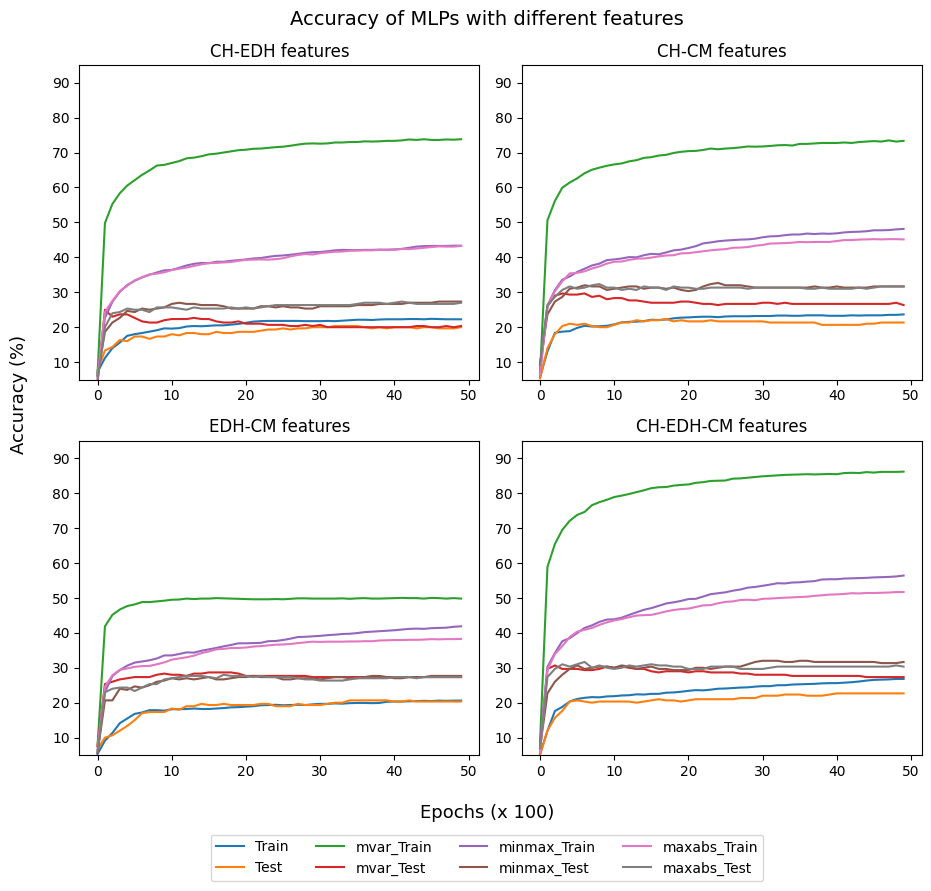

In [4]:
#show the accuracies of the different models
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = axs.flatten()

names = ['', '_mvar', '_minmax', '_maxabs']
for name in names:
    
    #CH-EDH
    df_accs = pd.read_csv(f'Results/ch_edh{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-EDH features', ax=axs[0], legend = False, xlabel='')
    axs[0].set_ylim([5, 95])

    #CH-CM
    df_accs = pd.read_csv(f'Results/ch_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-CM features', ax=axs[1], legend=False,xlabel='')
    axs[1].set_ylim([5, 95])

    #EDH-CM
    df_accs = pd.read_csv(f'Results/edh_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'EDH-CM features', ax=axs[2],  legend=False,xlabel='')
    axs[2].set_ylim([5, 95])

    #CH-EDH-CM
    df_accs = pd.read_csv(f'Results/ch_edh_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-EDH-CM features', ax=axs[3], legend=False,xlabel='')
    axs[3].set_ylim([5, 95])

#title
fig.suptitle(f'Accuracy of MLPs with different features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test', 'mvar_Train', 'mvar_Test', 'minmax_Train', 'minmax_Test', 'maxabs_Train', 'maxabs_Test'], loc = 'center', bbox_to_anchor=(0.5, -0.08), ncol=4)
fig.tight_layout()

### 2.2 ANALYSIS
##### Identify the pairs of classes that are more likely to be confused with neural features. Also identify the test images that are misclassified even if the classifier predicted their label with high confidence.

### **NOTE:** The analysis can be done to each model by changing the proper variable in the code below. In this case it is performed on the best performing model (neural features layer -5)

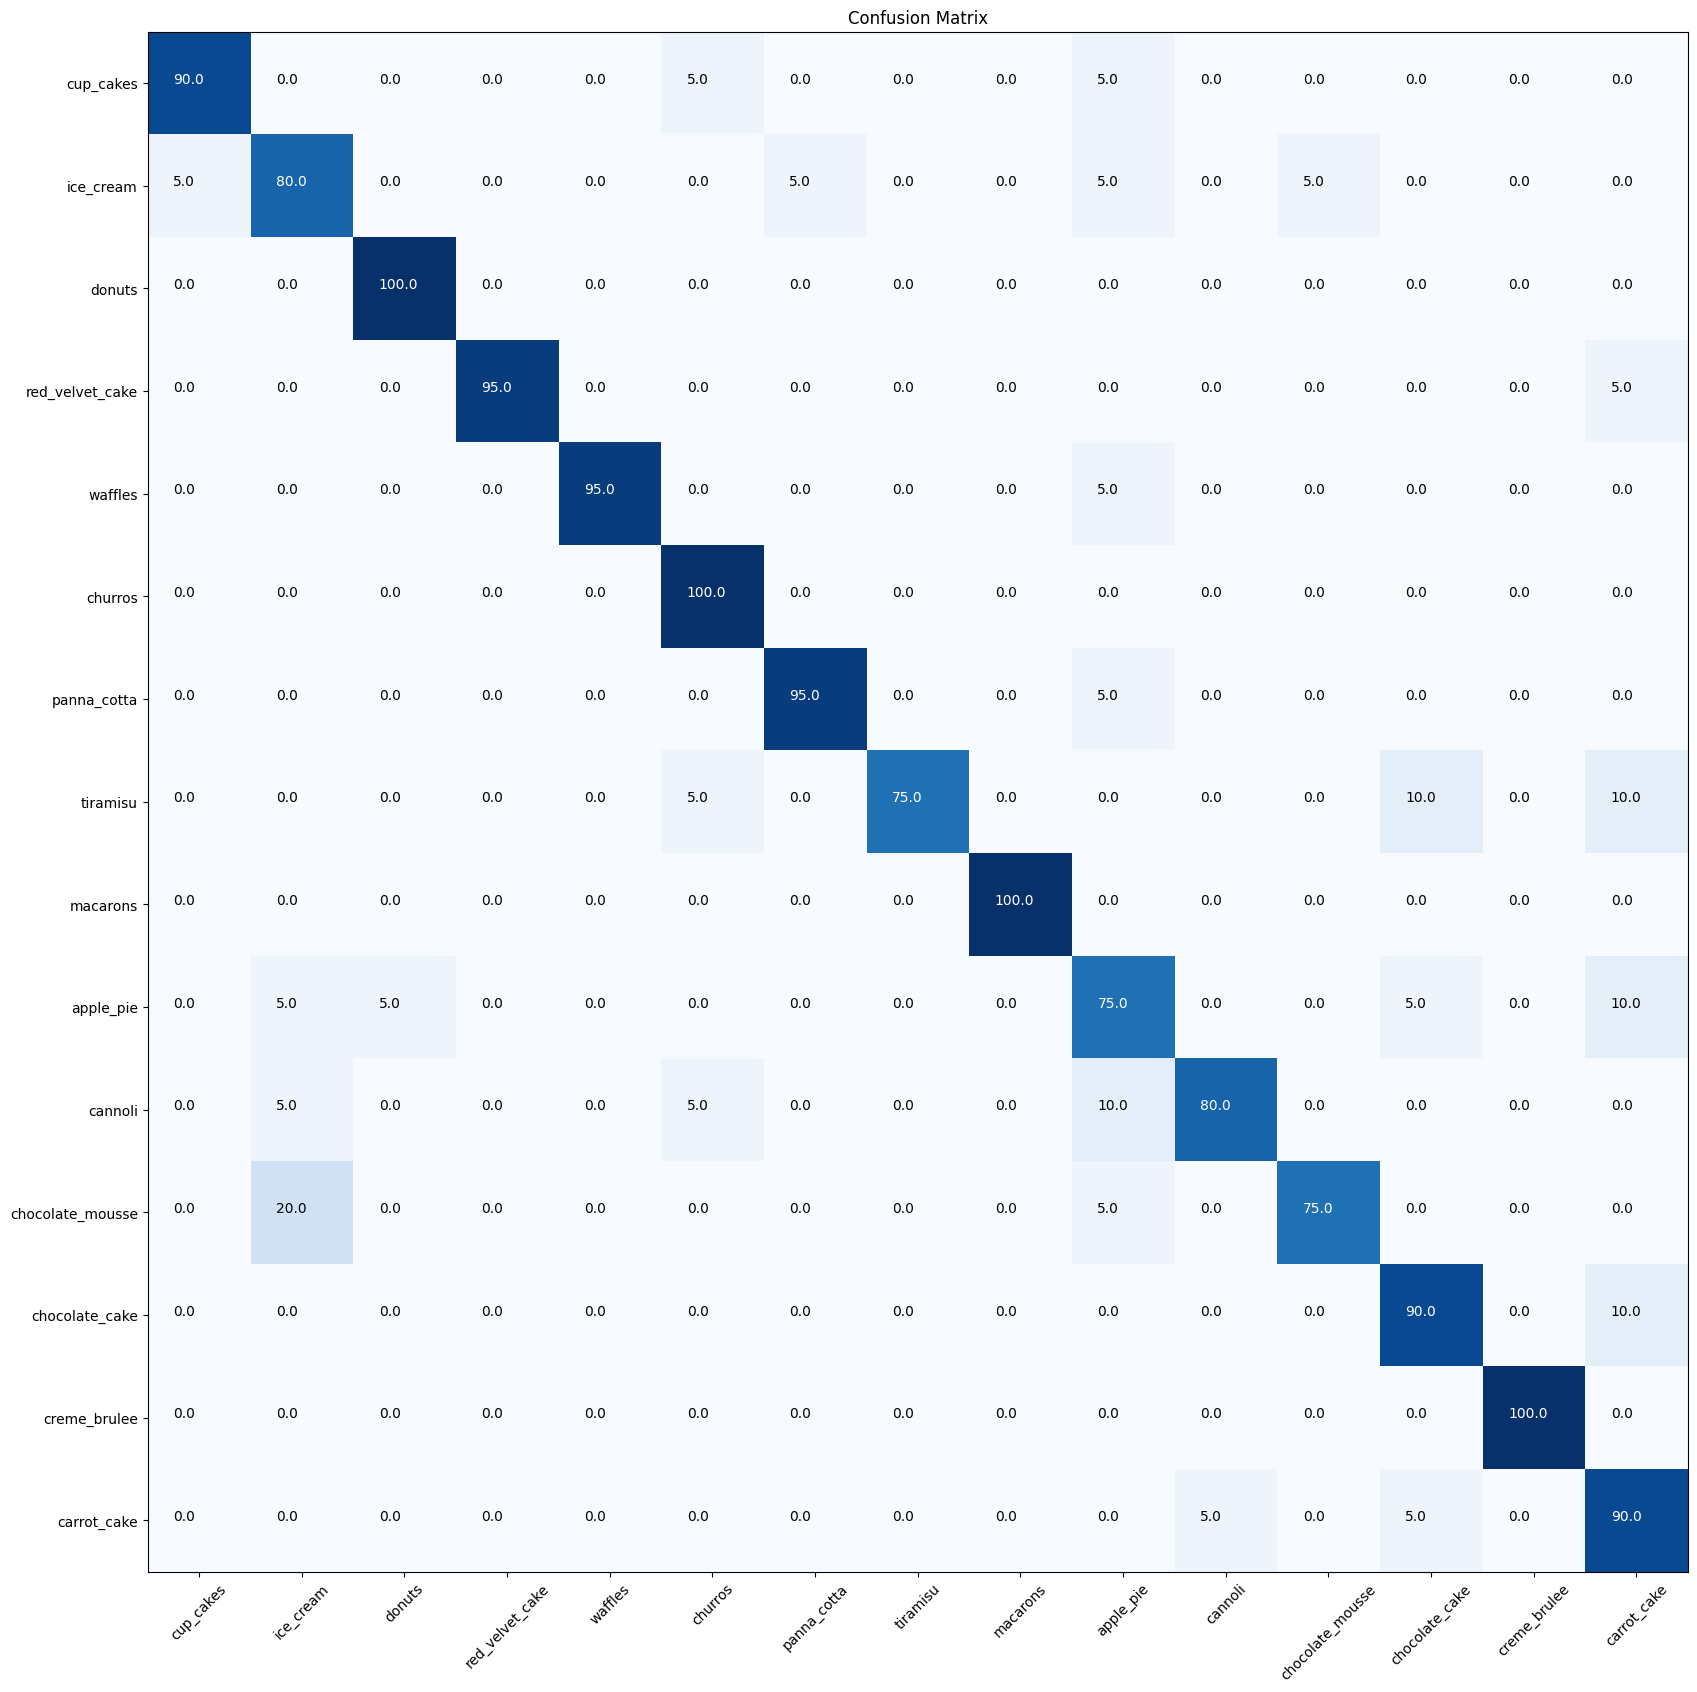

In [8]:
#analysis of the best model
classes = os.listdir('Data_gitignore/cake-classification/test')

#load the features
list_features = ccf.load_features(['neural-5_test']) #change the name of the file to load the features of the model you want to analyze
X_test, Y_test = list_features

#load the model
mlp = pvml.MLP.load('Trained_models/cnn-5_mlp.npz') #change the name of the file to load the model you want to analyze
predictions, probs = mlp.inference(X_test)

cm = ccf.confusion_matrix(Y_test, predictions, classes, show = True, rnorm = True)

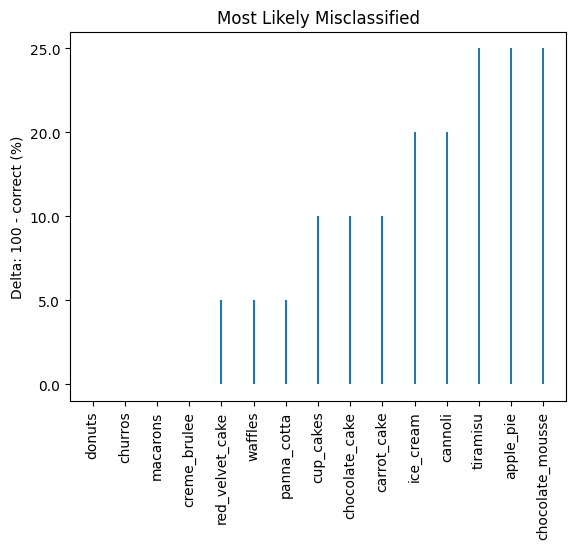

array([['donuts', 'churros', 'macarons', 'creme_brulee',
        'red_velvet_cake', 'waffles', 'panna_cotta', 'cup_cakes',
        'chocolate_cake', 'carrot_cake', 'ice_cream', 'cannoli',
        'tiramisu', 'apple_pie', 'chocolate_mousse'],
       ['0.0', '0.0', '0.0', '0.0', '5.0', '5.0', '5.0', '10.0', '10.0',
        '10.0', '20.0', '20.0', '25.0', '25.0', '25.0'],
       ['20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20',
        '20', '20', '20', '20']], dtype='<U32')

In [4]:
counters = np.bincount(Y_test)
classes = np.array(classes)
ccf.likely_misclassified(counters, cm, classes, 15, show = True)

the class 'cup_cakes' is frequently exchanged with 'churros'
the class 'ice_cream' is frequently exchanged with 'cup_cakes'
the class 'donuts' is frequently exchanged with 'cup_cakes'
the class 'red_velvet_cake' is frequently exchanged with 'carrot_cake'
the class 'waffles' is frequently exchanged with 'apple_pie'
the class 'churros' is frequently exchanged with 'cup_cakes'
the class 'panna_cotta' is frequently exchanged with 'apple_pie'
the class 'tiramisu' is frequently exchanged with 'chocolate_cake'
the class 'macarons' is frequently exchanged with 'cup_cakes'
the class 'apple_pie' is frequently exchanged with 'carrot_cake'
the class 'cannoli' is frequently exchanged with 'apple_pie'
the class 'chocolate_mousse' is frequently exchanged with 'ice_cream'
the class 'chocolate_cake' is frequently exchanged with 'carrot_cake'
the class 'creme_brulee' is frequently exchanged with 'cup_cakes'
the class 'carrot_cake' is frequently exchanged with 'cannoli'


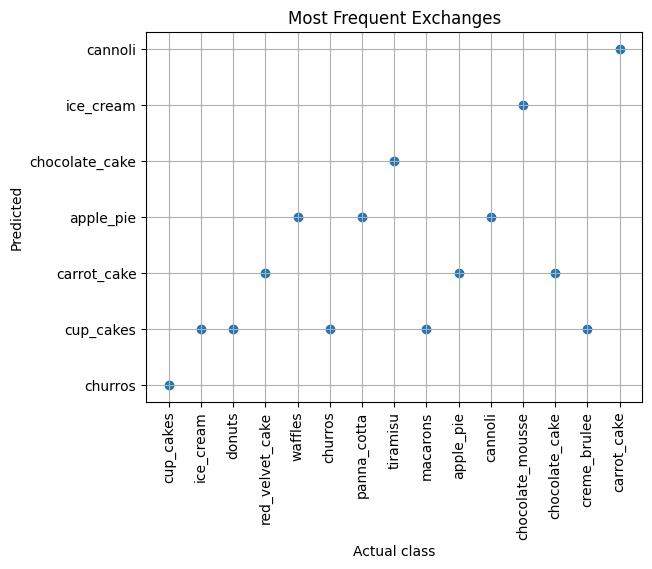

In [5]:
#print most frequent classes exchanges

wrong_labelled, wrong_valued = ccf.wrong_classes(cm, classes)
for j in range(15):
    print(f"the class '{wrong_labelled[0,j]}' is frequently exchanged with '{wrong_labelled[1,j]}'")

plt.figure()
plt.scatter(wrong_labelled[0,:], wrong_labelled[1,:])
plt.grid(True)
plt.xticks(rotation=90)
plt.title('Most Frequent Exchanges')
plt.xlabel('Actual class')
plt.ylabel('Predicted')
plt.show()

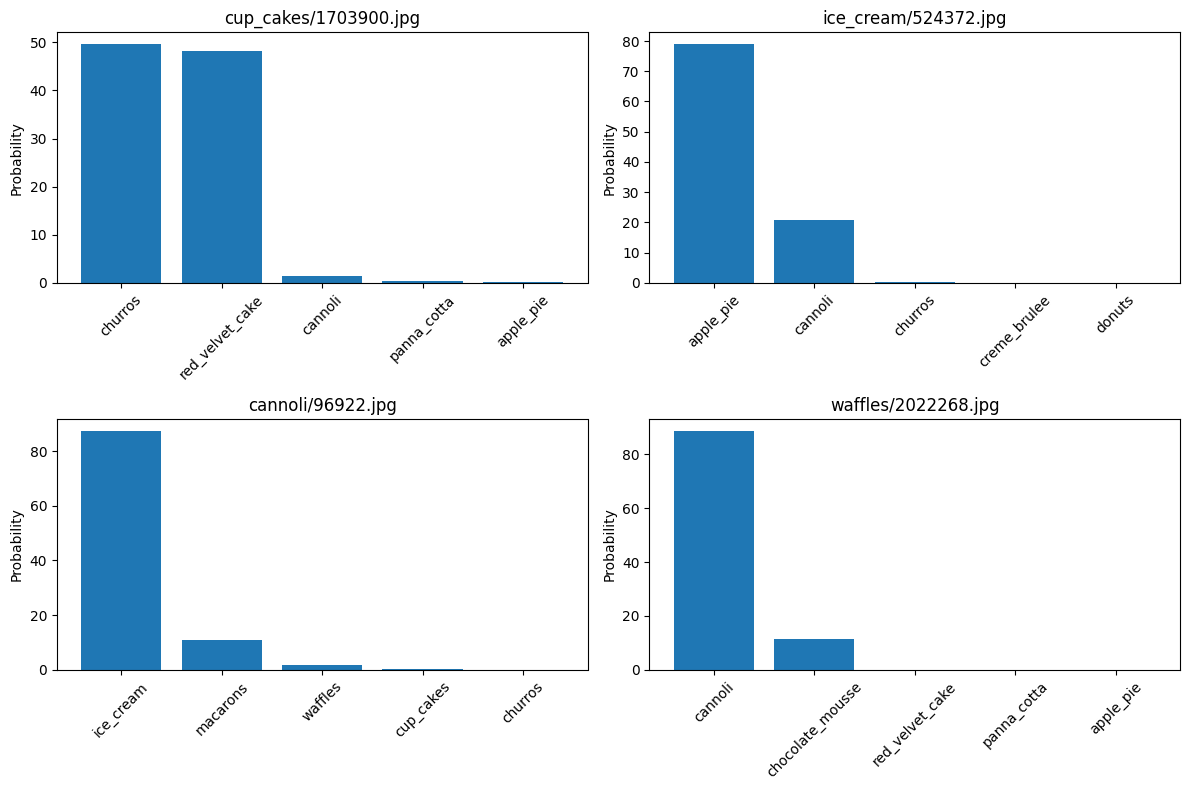

In [6]:
'''misclassified_index = np.where(predictions != Y_test)
#class_correct = Y_test[misclassified_index]
class_correct = (misclassified_index[:][0] // 20) % 20
class_wrong= predictions[misclassified_index]
in_class_pos = misclassified_index - class_correct*20
class_names_correct = [classes[i] for i in class_correct]
class_names_wrong = [classes[i] for i in class_wrong]

#create an array of two rows. The first contains the class names, the second the positions of the images misclassified in the class
misclassified_info = np.array([class_names_correct, in_class_pos])

for name_correct, pos, name_wrong in zip(class_names_correct,in_class_pos[0],class_names_wrong):
    c = os.listdir('Data_gitignore/cake-classification/test/' + name_correct)
    print(f"image '{c[pos]}' of class {name_correct} is misclassified as {name_wrong}")'''

#load model
cnn = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')

#create a barplot of the most likely classes for the inserted images

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
ccf.item_prediction('cup_cakes/1703900.jpg', classes, cnn, show = True)
plt.subplot(2, 2, 2)
ccf.item_prediction('ice_cream/524372.jpg', classes, cnn, show = True)
plt.subplot(2, 2, 3)
ccf.item_prediction('cannoli/96922.jpg', classes, cnn, show = True)
plt.subplot(2, 2, 4)
ccf.item_prediction('waffles/2022268.jpg', classes, cnn, show = True)
plt.tight_layout()

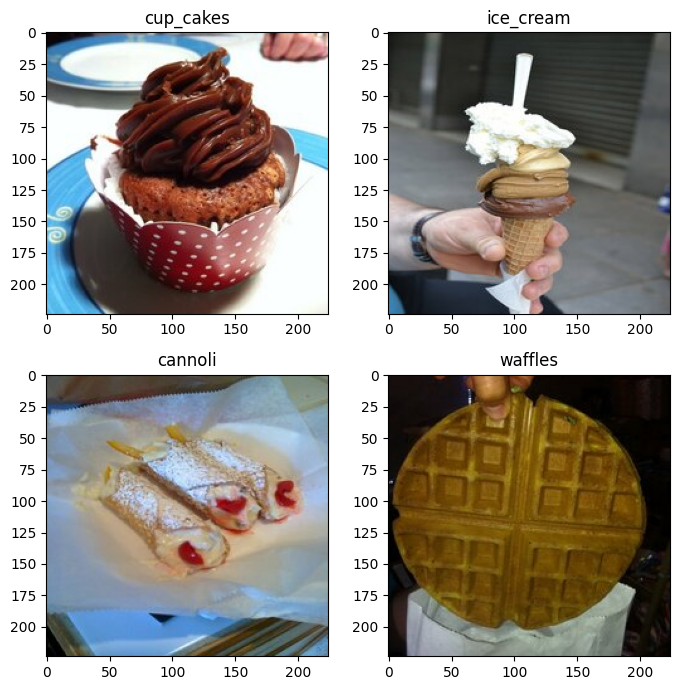

In [7]:
path = 'Data_gitignore/cake-classification/test/'
im1 = plt.imread(path + 'cup_cakes/1703900.jpg')
im2 = plt.imread(path + 'ice_cream/524372.jpg')
im3 = plt.imread(path + 'cannoli/96922.jpg')
im4 = plt.imread(path + 'waffles/2022268.jpg')

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs = axs.flatten()
axs[0].imshow(im1)
axs[0].set_title('cup_cakes')
axs[1].imshow(im2)
axs[1].set_title('ice_cream')
axs[2].imshow(im3)
axs[2].set_title('cannoli')
axs[3].imshow(im4)
axs[3].set_title('waffles')
fig.tight_layout()

### 2.3 NEURAL FEATURES
##### Try to use neural features computed by different hidden layers. When the activations are spatially distributed, you may reduce them to a single feature vector by averaging over the spatial dimensions.

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES

act_layer = -7 #layer with respect to which we want to fit the MLP

data = np.loadtxt(f"Features/neural{act_layer}_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt(f"Features/neural{act_layer}_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

#define and train the MLP
mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'cnn{act_layer}_mlp', filename = f'cnn{act_layer}_accs',store_model=True, store_accs = True)

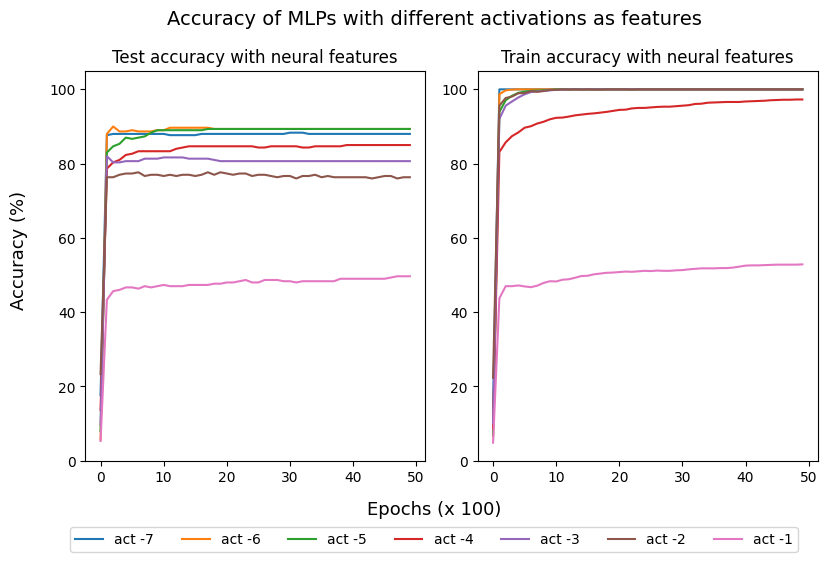

In [3]:
#plot the results relative to the different activations
act_layers = [-7, -6, -5, -4, -3, -2, -1]

fig, axs = plt.subplots(1,2, figsize = (8,5))
axs = axs.flatten()

for act_layer in act_layers:
    df_accs = pd.read_csv(f'Results/cnn{act_layer}_accs.csv')
    df_accs.plot(x = 'epoch', y = 'test_acc', title = 'Test accuracy with neural features', ax = axs[0], legend = False, xlabel = '')
    axs[0].set_ylim(0, 105)
    df_accs.plot(x = 'epoch', y = 'train_acc', title = 'Train accuracy with neural features', ax = axs[1], legend = False, xlabel = '')
    axs[1].set_ylim(0, 105)
    
#title
fig.suptitle(f'Accuracy of MLPs with different activations as features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['act -7', 'act -6', 'act -5', 'act -4', 'act -3', 'act -2', 'act -1', ], loc = 'center', bbox_to_anchor=(0.5, -0.08), ncol=7)
fig.tight_layout()



## Future Work
### 2.4 FINE TUNING
##### Try to fine-tune the CNN after transfer learning (i.e. continue training with as very small learning rate like 10−5).